In [ ]:
#| default_exp models.deepnpts

# DeepNPTS

Deep Non-Parametric Time Series Forecaster (`DeepNPTS`) is a non-parametric baseline model for time-series forecasting. This model generates predictions by sampling from the empirical distribution according to a tunable strategy. This strategy is learned by exploiting the information across multiple related time series. This model provides a strong, simple baseline for time series forecasting. 


**References**<br>
[Rangapuram, Syama Sundar, Jan Gasthaus, Lorenzo Stella, Valentin Flunkert, David Salinas, Yuyang Wang, and Tim Januschowski (2023). "Deep Non-Parametric Time Series Forecaster". arXiv.](https://arxiv.org/abs/2312.14657)<br>


:::{.callout-warning collapse="false"}
#### Losses

This implementation differs from the original work in that a weighted sum of the empirical distribution is returned as forecast. Therefore, it only supports point losses.

:::

In [ ]:
#| export
import torch
import torch.nn as nn
import torch.nn.functional as F
import neuralforecast.losses.pytorch as losses
from typing import Optional


from neuralforecast.common._base_windows import BaseWindows
from neuralforecast.losses.pytorch import MAE


In [ ]:
#| hide
import logging
import warnings

from fastcore.test import test_eq
from nbdev.showdoc import show_doc

In [ ]:
#| hide
logging.getLogger("pytorch_lightning").setLevel(logging.ERROR)
warnings.filterwarnings("ignore")

## 2. DeepNPTS

In [ ]:
#| export
class DeepNPTS(BaseWindows):
    """ DeepNPTS

    Deep Non-Parametric Time Series Forecaster (`DeepNPTS`) is a baseline model for time-series forecasting. This model generates predictions by (weighted) sampling from the empirical distribution according to a learnable strategy. The strategy is learned by exploiting the information across multiple related time series.

    **Parameters:**<br>
    `h`: int, Forecast horizon. <br>
    `input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
    `hidden_size`: int=32, hidden size of dense layers.<br>
    `batch_norm`: bool=True, if True, applies Batch Normalization after each dense layer in the network.<br>
    `dropout`: float=0.1, dropout.<br>
    `n_layers`: int=2, number of dense layers.<br>
    `stat_exog_list`: str list, static exogenous columns.<br>
    `hist_exog_list`: str list, historic exogenous columns.<br>
    `futr_exog_list`: str list, future exogenous columns.<br>
    `exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
    `loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
    `max_steps`: int=1000, maximum number of training steps.<br>
    `learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
    `num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
    `early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
    `val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
    `batch_size`: int=32, number of different series in each batch.<br>
    `valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
    `windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
    `inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
    `start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
    `step_size`: int=1, step size between each window of temporal data.<br>
    `scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
    `random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
    `num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
    `drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
    `alias`: str, optional,  Custom name of the model.<br>
    `optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
    `optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
    `**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

    **References**<br>
    - [Rangapuram, Syama Sundar, Jan Gasthaus, Lorenzo Stella, Valentin Flunkert, David Salinas, Yuyang Wang, and Tim Januschowski (2023). "Deep Non-Parametric Time Series Forecaster". arXiv.](https://arxiv.org/abs/2312.14657)<br>

    """
    # Class attributes
    SAMPLING_TYPE = 'windows'
    
    def __init__(self,
                 h,
                 input_size: int = -1,
                 hidden_size: int = 32,
                 batch_norm: bool = True,
                 dropout: float = 0.1,
                 n_layers: int = 2,
                 futr_exog_list = None,
                 hist_exog_list = None,
                 stat_exog_list = None,
                 exclude_insample_y = False,
                 loss = MAE(),
                 valid_loss = MAE(),
                 max_steps: int = 1000,
                 learning_rate: float = 1e-3,
                 num_lr_decays: int = 3,
                 early_stop_patience_steps: int =-1,
                 val_check_steps: int = 100,
                 batch_size: int = 32,
                 valid_batch_size: Optional[int] = None,
                 windows_batch_size: int = 1024,
                 inference_windows_batch_size: int = 1024,
                 start_padding_enabled = False,
                 step_size: int = 1,
                 scaler_type: str = 'standard',
                 random_seed: int = 1,
                 num_workers_loader = 0,
                 drop_last_loader = False,
                 optimizer = None,
                 optimizer_kwargs = None,
                 **trainer_kwargs):

        if exclude_insample_y:
            raise Exception('DeepNPTS has no possibility for excluding y.')

        if not isinstance(loss, losses.BasePointLoss):
            raise Exception('DeepNPTS only supports point loss functions (MAE, MSE, etc) as loss function.')               
    
        if not isinstance(valid_loss, losses.BasePointLoss):
            raise Exception('DeepNPTS only supports point loss functions (MAE, MSE, etc) as valid loss function.')   
            
        # Inherit BaseWindows class
        super(DeepNPTS, self).__init__(h=h,
                                    input_size=input_size,
                                    futr_exog_list=futr_exog_list,
                                    hist_exog_list=hist_exog_list,
                                    stat_exog_list=stat_exog_list,
                                    exclude_insample_y = exclude_insample_y,
                                    loss=loss,
                                    valid_loss=valid_loss,
                                    max_steps=max_steps,
                                    learning_rate=learning_rate,
                                    num_lr_decays=num_lr_decays,
                                    early_stop_patience_steps=early_stop_patience_steps,
                                    val_check_steps=val_check_steps,
                                    batch_size=batch_size,
                                    windows_batch_size=windows_batch_size,
                                    valid_batch_size=valid_batch_size,
                                    inference_windows_batch_size=inference_windows_batch_size,
                                    start_padding_enabled=start_padding_enabled,
                                    step_size=step_size,
                                    scaler_type=scaler_type,
                                    num_workers_loader=num_workers_loader,
                                    drop_last_loader=drop_last_loader,
                                    random_seed=random_seed,
                                    optimizer=optimizer,
                                    optimizer_kwargs=optimizer_kwargs,
                                    **trainer_kwargs)

        self.h = h
        self.hidden_size = hidden_size
        self.dropout = dropout

        self.futr_exog_size = len(self.futr_exog_list)
        self.stat_exog_size = len(self.stat_exog_list)
        self.hist_exog_size = len(self.hist_exog_list)

        input_dim = input_size * (1 + self.futr_exog_size + self.hist_exog_size) + self.stat_exog_size + self.h * self.futr_exog_size
        
        # Create DeepNPTSNetwork
        modules = []       
        for i in range(n_layers):
            modules.append(nn.Linear(input_dim if i == 0 else hidden_size, hidden_size))
            modules.append(nn.ReLU())
            if batch_norm:
                modules.append(nn.BatchNorm1d(hidden_size))
            if dropout > 0.0:
                modules.append(nn.Dropout(dropout))

        modules.append(nn.Linear(hidden_size, input_size * self.h))
        self.deepnptsnetwork = nn.Sequential(*modules)

    def forward(self, windows_batch):
        # Parse windows_batch
        x             = windows_batch['insample_y'].unsqueeze(-1)       #   [B, L, 1]
        hist_exog     = windows_batch['hist_exog']                      #   [B, L, X]
        futr_exog     = windows_batch['futr_exog']                      #   [B, L + h, F]
        stat_exog     = windows_batch['stat_exog']                      #   [B, S]

        batch_size, seq_len = x.shape[:2]                               #   B = batch_size, L = seq_len
        insample_y = windows_batch['insample_y'].unsqueeze(-1) 
        
        # Concatenate x_t with future exogenous of input
        if self.futr_exog_size > 0:      
            x = torch.cat((x, futr_exog[:, :seq_len]), dim=2)           #   [B, L, 1] + [B, L, F] -> [B, L, 1 + F]            
        
        # Concatenate x_t with historic exogenous
        if self.hist_exog_size > 0:      
            x = torch.cat((x, hist_exog), dim=2)                        #   [B, L, 1 + F] + [B, L, X] -> [B, L, 1 + F + X]            

        x = x.reshape(batch_size, -1)                                   #   [B, L, 1 + F + X] -> [B, L * (1 + F + X)]

        # Concatenate x with static exogenous
        if self.stat_exog_size > 0:
            x = torch.cat((x, stat_exog), dim=1)                        #   [B, L * (1 + F + X)] + [B, S] -> [B, L * (1 + F + X) + S]

        # Concatenate x_t with future exogenous of horizon
        if self.futr_exog_size > 0:
            futr_exog = futr_exog[:, seq_len:]                          #   [B, L + h, F] -> [B, h, F]
            futr_exog = futr_exog.reshape(batch_size, -1)               #   [B, L + h, F] -> [B, h * F]
            x = torch.cat((x, futr_exog), dim=1)                        #   [B, L * (1 + F + X) + S] + [B, h * F] -> [B, L * (1 + F + X) + S + h * F]            

        # Run through DeepNPTSNetwork
        weights = self.deepnptsnetwork(x)                               #   [B, L * (1 + F + X) + S + h * F]  -> [B, L * h]

        # Apply softmax for weighted input predictions
        weights = weights.reshape(batch_size, seq_len, -1)              #   [B, L * h] -> [B, L, h]
        x = F.softmax(weights, dim=1) * insample_y                      #   [B, L, h] * [B, L, 1] = [B, L, h]
        output = torch.sum(x, dim=1).unsqueeze(-1)                      #   [B, L, h] -> [B, h, 1]

        forecast = self.loss.domain_map(output)                         #   [B, h, 1] -> [B, h, 1]

        return forecast

In [ ]:
show_doc(DeepNPTS, title_level=3)

---

[source](https://github.com/Nixtla/neuralforecast/blob/main/neuralforecast/models/deepnpts.py#L18){target="_blank" style="float:right; font-size:smaller"}

### DeepNPTS

>      DeepNPTS (h, input_size:int=-1, hidden_size:int=32, batch_norm:bool=True,
>                dropout:float=0.1, n_layers:int=2, futr_exog_list=None,
>                hist_exog_list=None, stat_exog_list=None,
>                exclude_insample_y=False, loss=MAE(), valid_loss=MAE(),
>                max_steps:int=1000, learning_rate:float=0.001,
>                num_lr_decays:int=3, early_stop_patience_steps:int=-1,
>                val_check_steps:int=100, batch_size:int=32,
>                valid_batch_size:Optional[int]=None,
>                windows_batch_size:int=1024,
>                inference_windows_batch_size:int=1024,
>                start_padding_enabled=False, step_size:int=1,
>                scaler_type:str='standard', random_seed:int=1,
>                num_workers_loader=0, drop_last_loader=False, optimizer=None,
>                optimizer_kwargs=None, **trainer_kwargs)

DeepNPTS

Deep Non-Parametric Time Series Forecaster (`DeepNPTS`) is a baseline model for time-series forecasting. This model generates predictions by (weighted) sampling from the empirical distribution according to a learnable strategy. The strategy is learned by exploiting the information across multiple related time series.

**Parameters:**<br>
`h`: int, Forecast horizon. <br>
`input_size`: int, autorregresive inputs size, y=[1,2,3,4] input_size=2 -> y_[t-2:t]=[1,2].<br>
`hidden_size`: int=32, hidden size of dense layers.<br>
`batch_norm`: bool=True, if True, applies Batch Normalization after each dense layer in the network.<br>
`dropout`: float=0.1, dropout.<br>
`n_layers`: int=2, number of dense layers.<br>
`stat_exog_list`: str list, static exogenous columns.<br>
`hist_exog_list`: str list, historic exogenous columns.<br>
`futr_exog_list`: str list, future exogenous columns.<br>
`exclude_insample_y`: bool=False, the model skips the autoregressive features y[t-input_size:t] if True.<br>
`loss`: PyTorch module, instantiated train loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`valid_loss`: PyTorch module=`loss`, instantiated valid loss class from [losses collection](https://nixtla.github.io/neuralforecast/losses.pytorch.html).<br>
`max_steps`: int=1000, maximum number of training steps.<br>
`learning_rate`: float=1e-3, Learning rate between (0, 1).<br>
`num_lr_decays`: int=-1, Number of learning rate decays, evenly distributed across max_steps.<br>
`early_stop_patience_steps`: int=-1, Number of validation iterations before early stopping.<br>
`val_check_steps`: int=100, Number of training steps between every validation loss check.<br>
`batch_size`: int=32, number of different series in each batch.<br>
`valid_batch_size`: int=None, number of different series in each validation and test batch, if None uses batch_size.<br>
`windows_batch_size`: int=1024, number of windows to sample in each training batch, default uses all.<br>
`inference_windows_batch_size`: int=-1, number of windows to sample in each inference batch, -1 uses all.<br>
`start_padding_enabled`: bool=False, if True, the model will pad the time series with zeros at the beginning, by input size.<br>
`step_size`: int=1, step size between each window of temporal data.<br>
`scaler_type`: str='identity', type of scaler for temporal inputs normalization see [temporal scalers](https://nixtla.github.io/neuralforecast/common.scalers.html).<br>
`random_seed`: int, random_seed for pytorch initializer and numpy generators.<br>
`num_workers_loader`: int=os.cpu_count(), workers to be used by `TimeSeriesDataLoader`.<br>
`drop_last_loader`: bool=False, if True `TimeSeriesDataLoader` drops last non-full batch.<br>
`alias`: str, optional,  Custom name of the model.<br>
`optimizer`: Subclass of 'torch.optim.Optimizer', optional, user specified optimizer instead of the default choice (Adam).<br>
`optimizer_kwargs`: dict, optional, list of parameters used by the user specified `optimizer`.<br>
`**trainer_kwargs`: int,  keyword trainer arguments inherited from [PyTorch Lighning's trainer](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).<br>    

**References**<br>
- [Rangapuram, Syama Sundar, Jan Gasthaus, Lorenzo Stella, Valentin Flunkert, David Salinas, Yuyang Wang, and Tim Januschowski (2023). "Deep Non-Parametric Time Series Forecaster". arXiv.](https://arxiv.org/abs/2312.14657)<br>

In [ ]:
show_doc(DeepNPTS.fit, name='DeepNPTS.fit', title_level=3)

---

### DeepNPTS.fit

>      DeepNPTS.fit (dataset, val_size=0, test_size=0, random_seed=None,
>                    distributed_config=None)

Fit.

The `fit` method, optimizes the neural network's weights using the
initialization parameters (`learning_rate`, `windows_batch_size`, ...)
and the `loss` function as defined during the initialization.
Within `fit` we use a PyTorch Lightning `Trainer` that
inherits the initialization's `self.trainer_kwargs`, to customize
its inputs, see [PL's trainer arguments](https://pytorch-lightning.readthedocs.io/en/stable/api/pytorch_lightning.trainer.trainer.Trainer.html?highlight=trainer).

The method is designed to be compatible with SKLearn-like classes
and in particular to be compatible with the StatsForecast library.

By default the `model` is not saving training checkpoints to protect
disk memory, to get them change `enable_checkpointing=True` in `__init__`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`val_size`: int, validation size for temporal cross-validation.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`test_size`: int, test size for temporal cross-validation.<br>

In [ ]:
show_doc(DeepNPTS.predict, name='DeepNPTS.predict', title_level=3)

---

### DeepNPTS.predict

>      DeepNPTS.predict (dataset, test_size=None, step_size=1, random_seed=None,
>                        **data_module_kwargs)

Predict.

Neural network prediction with PL's `Trainer` execution of `predict_step`.

**Parameters:**<br>
`dataset`: NeuralForecast's `TimeSeriesDataset`, see [documentation](https://nixtla.github.io/neuralforecast/tsdataset.html).<br>
`test_size`: int=None, test size for temporal cross-validation.<br>
`step_size`: int=1, Step size between each window.<br>
`random_seed`: int=None, random_seed for pytorch initializer and numpy generators, overwrites model.__init__'s.<br>
`**data_module_kwargs`: PL's TimeSeriesDataModule args, see [documentation](https://pytorch-lightning.readthedocs.io/en/1.6.1/extensions/datamodules.html#using-a-datamodule).

## Usage Example

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

from neuralforecast import NeuralForecast
from neuralforecast.utils import AirPassengersPanel, AirPassengersStatic

Seed set to 1


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Predicting: |          | 0/? [00:00<?, ?it/s]

[]

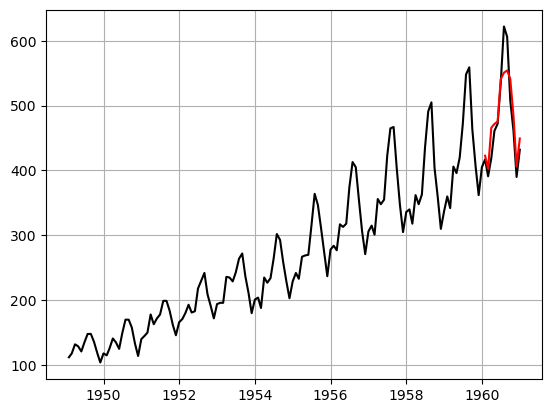

In [ ]:
#| eval: false
Y_train_df = AirPassengersPanel[AirPassengersPanel.ds<AirPassengersPanel['ds'].values[-12]] # 132 train
Y_test_df = AirPassengersPanel[AirPassengersPanel.ds>=AirPassengersPanel['ds'].values[-12]].reset_index(drop=True) # 12 test

nf = NeuralForecast(
    models=[DeepNPTS(h=12,
                   input_size=24,
                   stat_exog_list=['airline1'],
                   futr_exog_list=['trend'],
                   max_steps=1000,
                   val_check_steps=10,
                   early_stop_patience_steps=3,
                   scaler_type='robust',
                   enable_progress_bar=True),
    ],
    freq='M'
)
nf.fit(df=Y_train_df, static_df=AirPassengersStatic, val_size=12)
Y_hat_df = nf.predict(futr_df=Y_test_df)

# Plot quantile predictions
Y_hat_df = Y_hat_df.reset_index(drop=False).drop(columns=['unique_id','ds'])
plot_df = pd.concat([Y_test_df, Y_hat_df], axis=1)
plot_df = pd.concat([Y_train_df, plot_df])

plot_df = plot_df[plot_df.unique_id=='Airline1'].drop('unique_id', axis=1)
plt.plot(plot_df['ds'], plot_df['y'], c='black', label='True')
plt.plot(plot_df['ds'], plot_df['DeepNPTS'], c='red', label='mean')
plt.grid()
plt.plot()